In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Device: ',device)

Device:  cpu


## define NN structure

In [92]:
## define VAE structure
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1)
    
class VAE(nn.Module):
    def __init__(self, device, image_channels=1, h_dim=256, z_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            # 1 * 28 * 28
            nn.Conv2d(in_channels=image_channels, out_channels=16, 
                      kernel_size=4, stride=2),
            nn.ReLU(),
            # 16 * 13 * 13
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2),
            nn.ReLU(),
            # 32 * 6 * 6
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1),
            nn.ReLU(),
            # 64 * 4 * 4
            nn.Conv2d(in_channels=64, out_channels=256, 
                      kernel_size=4, stride=1),
            nn.ReLU(),
            # 256 * 1 * 1
            Flatten()
            # 256
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim) # for mu
        self.fc2 = nn.Linear(h_dim, z_dim) # for sigma
        self.fc3 = nn.Linear(z_dim, h_dim) # for decoder
        
        self.decoder = nn.Sequential(
            # 256
            UnFlatten(),
            # 256 * 1 * 1
            nn.ConvTranspose2d(h_dim, 64, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return std
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

## Define loss function

In [93]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

## Pre-define some Constant Variables

In [94]:
BATCH_SIZE = 32
EPOCH = 20
Z_DIM = 8

NORMAL_CLASS = 0
ABNORMAL_CLASS = 1

## Read data and pre-processing

In [95]:
# calculate the mean and std of 0 class data
# Load training Data
temp_dataset = datasets.MNIST(root='./MNIST', download=True, train=True,
                                transform=transforms.ToTensor()
                              )
# select ONLY 0 class as the normal case
zero_idx = temp_dataset.targets==NORMAL_CLASS
temp_dataset.targets = temp_dataset.targets[zero_idx]
temp_dataset.data = temp_dataset.data[zero_idx]

normMean = temp_dataset.data.float().mean().item()/255.
normStd  = temp_dataset.data.float().std().item()/255.

# normMean = 0.0
# normStd  = 1.0

print(normMean, normStd)

0.1733993081485524 0.34771797329771753


In [109]:
# Reload training Data
train_dataset = datasets.MNIST(root='./MNIST', download=True, train=True,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize((normMean,), (normStd,))])
                              )
# select ONLY 0 class as the normal case
zero_idx = train_dataset.targets==NORMAL_CLASS
train_dataset.targets = train_dataset.targets[zero_idx]
train_dataset.data = train_dataset.data[zero_idx]

# define data loader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=1, pin_memory=True)

# Load testing Data
test_dataset = datasets.MNIST(root='./MNIST', download=True, train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize((normMean,), (normStd,))])
                              )
# select 0 and 1 class for detection, i.e. 1 class is considered as abnormal case
zero_idx = test_dataset.targets==NORMAL_CLASS
one_idx  = test_dataset.targets==ABNORMAL_CLASS
test_dataset.data = torch.cat([test_dataset.data[zero_idx], test_dataset.data[one_idx]])
test_dataset.targets = torch.cat([test_dataset.targets[zero_idx], test_dataset.targets[one_idx]])
# define data loader
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                              shuffle=False, num_workers=1, pin_memory=True)

In [112]:
train_dataset.data[0].shape

torch.Size([28, 28])

## Define and train model

In [97]:
model = VAE(device, z_dim=Z_DIM).to(device)
print('Model: \n', model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Model: 
 VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=256, out_features=8, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=256, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2))
    (8): Sigmoid()
  )
)


In [98]:
## train model
best_LOSS = 1e10
for epoch in range(EPOCH):
    LOSS = 0.
    for idx, (images, _) in enumerate(train_dataloader):
        images = images.to(device)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    to_print = "Epoch[{}/{}], Iter: {}, Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, EPOCH, idx,
                        loss.data.item()/BATCH_SIZE,
                        bce.data.item()/BATCH_SIZE, 
                        kld.data.item()/BATCH_SIZE)
    print(to_print)
    # test and choose the best model
#     model.eval()
#     with torch.no_grad():
#         for idx, (images, target) in enumerate(test_dataloader):
#             if target == 0:
#                 images = images.to(device)
#                 recon_images, mu, logvar = model(images)
#                 loss_t, _, _ = loss_fn(recon_images, images, mu, logvar)
#                 LOSS += loss_t
#         if LOSS<best_LOSS:
#             best_LOSS = LOSS
#             torch.save(model.state_dict(), 'fdd_vae.torch')
#         print('LOSS: ', LOSS, 'best LOSS: ', best_LOSS)
                
#     model.train()

# model.load_state_dict(torch.load('fdd_vae.torch'))
torch.save(model.state_dict(), 'fdd_vae.torch')

Epoch[1/20], Iter: 185, Loss: -1257.403 -1278.177 20.774
Epoch[2/20], Iter: 185, Loss: -1296.882 -1307.702 10.820
Epoch[3/20], Iter: 185, Loss: -1357.295 -1366.249 8.955
Epoch[4/20], Iter: 185, Loss: -1371.934 -1383.823 11.889
Epoch[5/20], Iter: 185, Loss: -1292.195 -1307.197 15.002
Epoch[6/20], Iter: 185, Loss: -1273.728 -1284.099 10.370
Epoch[7/20], Iter: 185, Loss: -1379.567 -1386.109 6.543
Epoch[8/20], Iter: 185, Loss: -1217.715 -1225.802 8.087
Epoch[9/20], Iter: 185, Loss: -1286.666 -1293.155 6.489
Epoch[10/20], Iter: 185, Loss: -1315.189 -1319.941 4.752
Epoch[11/20], Iter: 185, Loss: -1285.948 -1293.415 7.467
Epoch[12/20], Iter: 185, Loss: -1328.306 -1334.425 6.119
Epoch[13/20], Iter: 185, Loss: -1383.171 -1387.225 4.054
Epoch[14/20], Iter: 185, Loss: -1291.143 -1295.454 4.312
Epoch[15/20], Iter: 185, Loss: -1281.193 -1285.034 3.841
Epoch[16/20], Iter: 185, Loss: -1260.608 -1264.597 3.988
Epoch[17/20], Iter: 185, Loss: -1277.581 -1280.383 2.803
Epoch[18/20], Iter: 185, Loss: -133

# simply test the performance of VAE

In [99]:
rand_index = torch.randint(0,len(test_dataset),(64,))
test_tensor = torch.stack([test_dataset[i][0].clone().to(device) for i in rand_index])
recon_tensor = model(test_tensor)

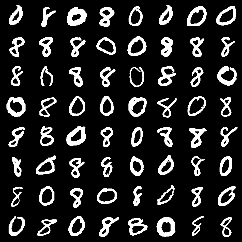

In [100]:
save_image(test_tensor.view(test_tensor.size(0), 1, 28, 28).data, 'test_image_orig.png')
Image('test_image_orig.png')

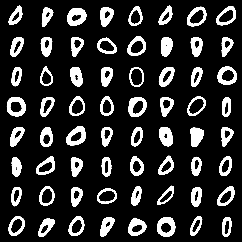

In [101]:
save_image(recon_tensor[0].view(recon_tensor[0].size(0), 1, 28, 28).data, 'test_image_recon.png')
Image('test_image_recon.png')

**From the reconstructure performance, we can see that VAE has learnt how to re-generate "zeros", but not "ones". **

## FDD via VAE

In [102]:
CLA = {'zero':{'mean':[], 'var':[]},
         'one' :{'mean':[], 'var':[]}}

with torch.no_grad():
    for i in range(100):
        test_case = test_dataset[torch.randint(0,len(test_dataset),(1,)).item()]
        test_z, test_mu, test_logvar = model.encode(test_case[0].unsqueeze(0).to(device))
        c = 'zero' if test_case[1]==NORMAL_CLASS else 'one'
        CLA[c]['mean'].append(test_mu.squeeze())
        CLA[c]['var'].append(test_logvar.exp_().squeeze())

CLA['zero']['mean'] = torch.stack(CLA['zero']['mean'])
CLA['zero']['var'] = torch.stack(CLA['zero']['var'])
CLA['zero']['M'] = torch.mean(CLA['zero']['mean'], dim=0)
CLA['zero']['S'] = torch.mean(CLA['zero']['var'], dim=0).sqrt()

CLA['one']['mean'] = torch.stack(CLA['one']['mean'])
CLA['one']['var'] = torch.stack(CLA['one']['var'])
CLA['one']['M'] = torch.mean(CLA['one']['mean'], dim=0)
CLA['one']['S'] = torch.mean(CLA['one']['var'], dim=0).sqrt()

#     print('Class: ', test_case[1])
#     print('mu',test_mu)
#     print('var', torch.exp(test_logvar))
# for idx, (data, target) in enumerate(test_dataloader):
#     model(data)

In [103]:
import numpy as np

def gaussian_distrib(mean=0., std=1.):
    x = np.linspace(mean-5.0*std, mean+5.0*std, 500)
    y = np.exp(-(x-mean)**2/(2.0*std**2)) / (std*np.sqrt(2.0*np.pi))
    
    return (x,y)

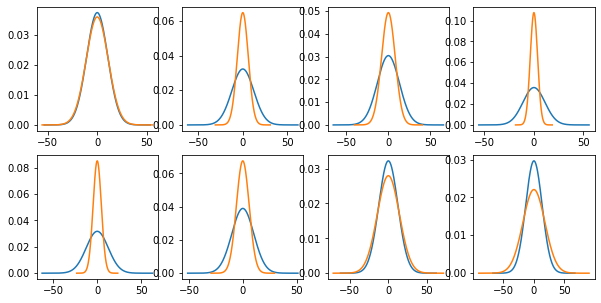

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10/4*np.ceil(Z_DIM/4)))
for p in range(Z_DIM):
    zero_x,zero_y = gaussian_distrib(CLA['zero']['M'][p].cpu().item(),
                     CLA['zero']['S'][p].cpu().item())
    one_x,one_y = gaussian_distrib(CLA['one']['M'][p].cpu().item(),
                     CLA['one']['S'][p].cpu().item())
    plt.subplot(np.ceil(Z_DIM/4), 4, p+1)
    plt.plot(zero_x,zero_y, one_x,one_y)
    if p==Z_DIM-1:
        plt.legend(('normal', 'abnormal'), 
           bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.)

### calculate the latent statistic (KL divergence)  and residual statistic (R)

In [105]:
## caulcate the prior distribution p(z)
prior_mu = []
prior_logvar = []
with torch.no_grad():
    for idx, (data, target) in enumerate(train_dataloader):
        z, mu, logvar = model.encode(data.to(device))
        prior_mu.append(mu)
        prior_logvar.append(logvar)
    
prior_mu = torch.cat(prior_mu).mean(dim=0)
prior_var = torch.cat(prior_logvar).exp_().mean(dim=0)

For two Gaussian distribution $p$ and $q$:

$D_{KL}(p||q) = \frac{1}{2}\left[\log\frac{|\Sigma_q|}{|\Sigma_p|} - k + (\boldsymbol{\mu_p}-\boldsymbol{\mu_q})^T\Sigma_q^{-1}(\boldsymbol{\mu_p}-\boldsymbol{\mu_q}) + tr\left\{\Sigma_q^{-1}\Sigma_p\right\}\right]$

The residual can be calculated by:

$\frac{1}{2} (x_i -f(z_{i,s}))^T \Sigma ^{-1} (z_{i,s}) (x_i-f(z_{i,s})) + \frac{1}{2} |\Sigma (z_{i,s})|$

In [106]:
# calculate the control limit


In [107]:
import pandas as pd
D_KL = pd.DataFrame(columns=['index', 'target', 'mean', 'var', 'KL', 'R'])

Sigma_p = torch.diag(prior_var)

with torch.no_grad():
    FDD_case_index = torch.randint(0,len(test_dataset),(200,))
    for i, idx in enumerate(FDD_case_index):
        test_case = test_dataset[idx.item()]
        test_z, test_mu, test_logvar = model.encode(test_case[0].unsqueeze(0).to(device))
        
        var_q = test_logvar.exp()
        Sigma_q = var_q.squeeze().diag()
        
        # calculate the KL divergence between each new case and prior distribution
        KL = 0.5*(torch.log(torch.norm(Sigma_q)/torch.norm(Sigma_p)) - Z_DIM 
                  + (prior_mu-test_mu).mm(Sigma_q.inverse()).mm((prior_mu-test_mu).transpose(0,1))
                  + torch.trace(Sigma_q.inverse()*Sigma_p))
        
        # calculate the R
        R = torch.norm(model(test_case[0].unsqueeze(0).to(device))[0] - test_case[0].unsqueeze(0).to(device)[0])
        
        D_KL.loc[i,:] = [idx.item(), test_case[1], test_mu.tolist(), var_q.tolist(), KL.item(), R.item()]

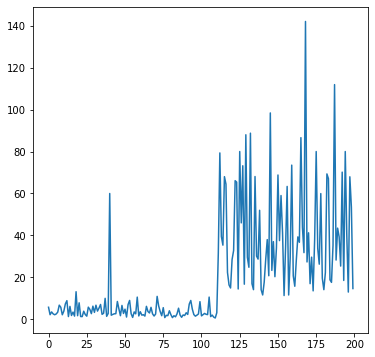

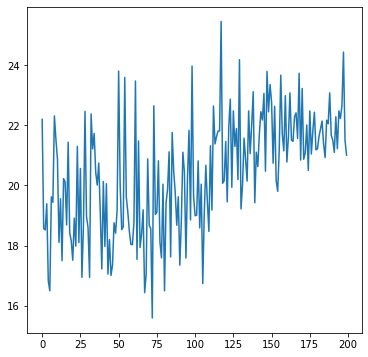

In [108]:
AS = True if NORMAL_CLASS < ABNORMAL_CLASS else False
plt.figure(figsize=(6,6))
plt.plot(D_KL.sort_values(by='target', ascending=AS)['KL'].tolist())
plt.figure(figsize=(6,6))
plt.plot(D_KL.sort_values(by='target', ascending=AS)['R'].tolist())